# Reading and cleaning of the data

In [1]:
import pandas as pd
import numpy as np
from importlib import import_module, reload
import functions as f
import matplotlib.pyplot as plt

def load_data():
    df_doc = pd.read_csv('data_univ/insertion-professionnelle-des-diplomes-de-doctorat-par-ensemble.csv', 
                         delimiter=';', na_values=('ns','nd','.'))
    df_mas = pd.read_csv('data_univ/fr-esr-insertion_professionnelle-master.csv', 
                         delimiter=';', na_values=('ns','nd','.'))
    df_lp = pd.read_csv('data_univ/fr-esr-insertion_professionnelle-lp.csv', 
                        delimiter=';', na_values=('ns','nd','.'))
    df_dut = pd.read_csv('data_univ/fr-esr-insertion_professionnelle-dut_donnees_nationales.csv', 
                         delimiter=';', na_values=('ns','nd','.'))
    univ_names = pd.read_csv('data_univ/fr-esr-principaux-etablissements-enseignement-superieur.csv', 
                             delimiter=";", na_values=('ns','nd','.'))
    return df_doc, df_mas, df_lp, univ_names

def rename_cols(name_dct, df):
    df.rename(columns=name_dct, errors="raise", inplace=True)
    return df
def concat_dfs(dfs_lst):
    df = dfs_lst[0]
    for i in range(1, len(dfs_lst)):
        df = pd.concat([df, dfs_lst[i]])
    return df

# import_module(functions)
def df_clean(df, cols_to_keep):
    df_new = df
    df_new = f.keep_rows_without_remarks(df_new)
    #df_new = df_new[df_new["Taux d’insertion"]].dropna()
    df_new = f.keep_columns(df_new, cols_to_keep)
    df_new["Diploma Domain"] = df_new["Diplôme"] + " " + df_new["Domaine"]
    df_new["taux temp plein - out of number of answers"] = df_new["Taux d’insertion"] * df_new["% emplois à temps plein"]/100
    return df_new

def merge_uni_all(univ_df, main_df):
    out_df = main_df.copy()
    univ_red = univ_df[["uai - identifiant","Libellé", 
                           "type d'établissement","Secteur d'établissement", 
                           "Géolocalisation"]]

    out_df = pd.merge(out_df, univ_red, how='left', 
                      left_on="Numéro de l'établissement",
                      right_on="uai - identifiant",
                      left_index=False, right_index=False)
    return out_df

In [2]:
doc_name_dct = {"NUMERO_UAI_Courant": "Numéro de l'établissement", 
                       "Année d’obtention": "Annee", 
                       "Situation": "situation",
                       "Part de femmes diplômées":"% femmes",
                       "Nombre de répondant":"Nombre de réponses",
                       "Part de docteurs déclarant avoir été financés pour réaliser leur thèse":"% de diplômés boursiers",
                       "Taux d’emploi stable":"% emplois stables",
                       "Taux d’emploi cadre":"% emplois cadre",
                       "Taux d’emploi à temps plein":"% emplois à temps plein",
                       "Salaire net mensuel médian des emplois à temps plein":"Salaire net médian des emplois à temps plein",
                       "Salaire brut annuel moyen estimé":"Salaire brut annuel estimé",
                       "Taux d'insertion":"Taux d’insertion",
                       "Discipline principale agrégée de l’école doctorale":"Domaine"
                      }

df_doc, df_mas, df_lp, univ_names = load_data()
df_doc = rename_cols(doc_name_dct, df_doc)
df_all = concat_dfs([df_lp, df_mas, df_doc])

In [3]:
# df_sit_1 = df_doc.loc[:,["Numéro de l'établissement",'situation', "Taux d'insertion"]]
# max_t = pd.DataFrame(df_sit.groupby(by="Numéro de l'établissement")["Taux d'insertion"].max())
# min_t =  pd.DataFrame(df_sit.groupby(by="Numéro de l'établissement")["Taux d'insertion"].min())
# # df_sit['taux diff'] = df_sit['max taux']-df_sit['min taux']
# pd.concat([max_t, min_t], axis=1,join='inner')

In [4]:
# Keeping only informative for this project columns
cols_to_keep = [0, 1, 2, 5, 7, 9, 10, 11, 12, 13, 15, 18, 19, 20, 23, 26]
df_all = df_clean(df_all, cols_to_keep)

In [5]:
# Adding university names
df_all = merge_uni_all(univ_names, df_all)

## Plotting function

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

In [7]:
# d_domains = np.unique(df_all["Diploma Domain"])
def tperiod(n):
    dct = {1: ['12 mois après le diplôme', '18 mois après le diplôme'],
           3: ['30 mois après le diplôme', '36 mois après le diplôme']}
    return dct[n]
def col_name_by_key(key):
    dct = {'job placement': "Taux d’insertion",
            'salary': "Salaire net médian des emplois à temps plein",
            'full time':''}
    return dct[key]

def d_domains():
    d_doms = [
        'DOCTORAT Sciences du vivant',
        'DOCTORAT Sciences humaines et humanités',
        'DOCTORAT Sciences et leurs interactions',
        'MASTER ENS Masters enseignement',
        'MASTER LMD Droit, économie et gestion',
        'MASTER LMD Lettres, langues, arts',
        'MASTER LMD Sciences humaines et sociales',
        'MASTER LMD Sciences, technologies et santé',
        'LICENCE PRO Droit, économie et gestion',
        'LICENCE PRO Lettres, langues, arts',
        'LICENCE PRO Sciences humaines et sociales',
        'LICENCE PRO Sciences, technologies et santé']
    return d_doms

def lbls(key1,key2):
#     plot_labels = {1: {"job placement": {'lims': (60, 101, 5), 
#                       'label': "Job placement rates, %",
#                       'title': 'Job placement: 12-18 months after graduation'}, 
#                 "salary": {'lims': (1000, 2900, 250), 
#                   'label': "Net monthly salary in euros",
#                   'title': 'Full time job monthly salaries: 12-18 months after graduation'}},
#               3: {"job placement": {'lims': (60, 101, 5), 
#                    'label': "Job placement rates, %",
#                    'title': 'Job placement: 30-36 months after graduation'}, 
#                   "salary": {'lims': (1000, 2900, 250), 
#                              'label': "Net monthly salary in euros",
#                              'title': 'Full time job monthly salaries: 30-36 months after graduation'}}}
    plot_labels = {"job placement": {'lims': (60, 101, 5), 
                      'label': "Job placement rates, %",
                      'title': 'Job placement: 3 years after graduation'}, 
                "salary": {'lims': (1000, 2900, 250), 
                  'label': "Net monthly salary in euros",
                  'title': 'Full time job monthly salaries: 3 years after graduation'}}
    return plot_labels[key1][key2]

def domain_labels():
    labels = [['Life Sciences',
               'Social and Humanity Sciences',
               'Sciences and Their Interactions'],
              ['Masters Teaching',
               'Law, Economics, Management',
                'Lettres, Langues, Arts',
                'Social and Humanity Sciences',
                'Science, Technology and Health'],
              ['Law, Economics, Management', 
                 'Letters, Languages, Arts', 
                 'Social and Humanity Sciences',
                 'Science, Technology and Health']]
    return labels

def domain_colors():
    colors = [['lightgreen', 'lightyellow', 'lightblue'], 
              ['orchid', 'darkorange', 'salmon', 'lightyellow', 'lightblue'], 
              ['orange', 'salmon', 'lightyellow', 'lightblue']]
    return colors

def cond_sit(df, time_per, key):
    return df["situation"] == tperiod(time_per)[key]

def cond_dd(df, d_domain):
    return df["Diploma Domain"] == d_domain

def dfs_to_plot(df, plot_par,  time_per):
    cond_1 = cond_sit(df, time_per, 0) 
    cond_2 = cond_sit(df, time_per, 1)
    cond_3 = lambda x: cond_dd(df, x)
    cond =  cond_1 | cond_2
    
    s_col = col_name_by_key(plot_par)
    
    return [df[(cond_3(d_domain) & cond)][s_col].dropna() for d_domain in d_domains()]
    
def sub_titles():
    return ["DOC", "MAS",'BAC']

def ax_plot(df_plots, ax, i, f_s, x_lbls, y_lims, plot_par, time_per, alpha):
    if alpha < 1:
        box = ax[i].boxplot(df_plots[i], 0, ".", 0, 
                            labels=domain_labels()[i],
                            patch_artist=True, 
                            boxprops=dict(alpha=alpha), 
                            whiskerprops=dict(alpha=alpha))
    else:
        box = ax[i].boxplot(df_plots[i], 0, "+", 0, 
                            labels=domain_labels()[i],
                            patch_artist=True, 
                            boxprops=dict(alpha=alpha), 
                            whiskerprops=dict(alpha=alpha))

    for patch, color in zip(box['boxes'], domain_colors()[i]):
        patch.set_facecolor(color)
    ax[i].tick_params(axis='both', which='minor', labelsize=f_s)
    ax[i].set_title(x_lbls[i], fontsize=f_s)
    ax[i].set_xlim([y_lims[0],y_lims[1]])
    ax[i].set_yticklabels(domain_labels()[i], fontsize=f_s)#rotation=90,
    if i == 0:
        ax[0].set_xticklabels([])
    elif i == 1:
        ax[1].set_xticklabels([])
    elif i == 2:
        ax[2].set_xlabel(lbls(plot_par,"label"), fontsize=f_s)
        ax[2].set_xticklabels(list(range(y_lims[0],y_lims[1],y_lims[2])), fontsize=f_s)

def plot_domain_wise(df, plot_par, filename):
    
    fig, ax = plt.subplots(3, 1, figsize=(10,5))
    
    for time_per, alpha in zip([1,3],[0.3,1]):
        df_sals = dfs_to_plot(df, plot_par, time_per)
        df_plots = [df_sals[:3], df_sals[3:8], df_sals[8:]]

        f_s = 12
        x_lbls = sub_titles()
        y_lims = lbls(plot_par,'lims')

        for i in range(len(domain_labels())):
            ax_plot(df_plots, ax, i, f_s, x_lbls, y_lims, plot_par, time_per, alpha)
    
    fig.suptitle(lbls(plot_par,"title"), fontsize=f_s+2)
    fig.savefig(filename, bbox_inches='tight')
    plt.show()


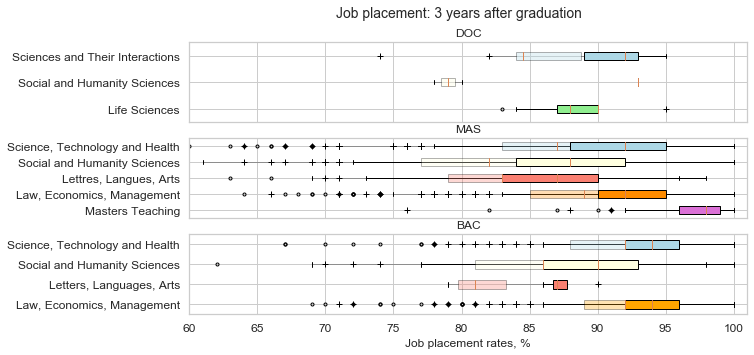

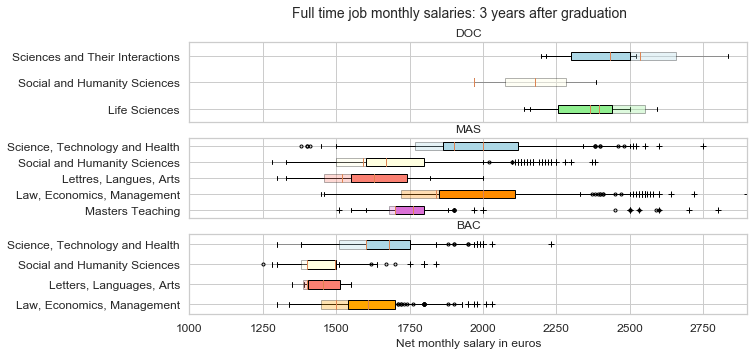

In [8]:
plot_domain_wise(df_all, "job placement", "job_placement.png")
plot_domain_wise(df_all, "salary", "salary.png")

In [9]:
print(f'Total number of answers from students: {df_all["Nombre de réponses"].dropna().sum()}')

Total number of answers from students: 1933064.0


# Best universities

In [10]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16214 entries, 0 to 16213
Data columns (total 23 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Annee                                         16214 non-null  int64  
 1   Diplôme                                       16214 non-null  object 
 2   Numéro de l'établissement                     16214 non-null  object 
 3   Académie                                      15827 non-null  object 
 4   Domaine                                       16214 non-null  object 
 5   Discipline                                    16180 non-null  object 
 6   situation                                     16214 non-null  object 
 7   Remarque                                      0 non-null      object 
 8   Nombre de réponses                            16207 non-null  float64
 9   Taux de réponse                               16069 non-null 

In [11]:
def univ_ranking(df):
    """
    Adds a column "rank" to the dataframe. And populates it with ranks of universities from top 20.
    """
    ranks_dct = {
        'Université Sorbonne Paris Nord':2,
        'Aix-Marseille Université': 4,
        'Université Grenoble Alpes':5,
        'Université de Strasbourg':6,
        'Université de Montpellier':8,
        'Université Claude Bernard - Lyon 1':9,
        'Université de Toulouse 3 - Paul Sabatier':10,
        'Université de Bordeaux':11,
        'Université Toulouse 1 - Capitole':12,
        'Université de Lille':18,
        'Université de Lorraine':19
    }
    df['rank'] = np.nan
    for uni in ranks_dct.keys():
        df.loc[df["Libellé"] == uni,"rank"] = ranks_dct[uni]

univ_ranking(df_all)

In [12]:
df_all['rank'].head(30)

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
6     4.0
7     4.0
8     4.0
9     NaN
10    NaN
11    NaN
12    NaN
13    NaN
14    NaN
15    NaN
16    NaN
17    NaN
18    NaN
19    NaN
20    NaN
21    NaN
22    NaN
23    NaN
24    NaN
25    NaN
26    NaN
27    NaN
28    NaN
29    NaN
Name: rank, dtype: float64

## Map tricks

In [13]:
import folium
from folium import plugins
import matplotlib as plt

In [14]:
m = folium.Map(location=[47.0000, 2.0000], zoom_start=5.0, width=400, height=400)

In [67]:
# deps_geo = 'data_univ/departements.geojson'

# folium.Choropleth(
#     geo_data=deps_geo,
#     name='choropleth',
#      data=deps_geo
#     columns=['Académie', 'Taux d’insertion'],
#     key_on='feature.id',
#     fill_color='YlGn',
#     fill_opacity=0.7,
#     line_opacity=0.2,
#     legend_name='Unemployment Rate (%)'
# ).add_to(m)

# folium.LayerControl().add_to(m)

In [68]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="test_name")
location = geolocator.geocode("Paris")
print(location.address)
print((location.latitude, location.longitude))
print(location.raw)

Paris, Île-de-France, France métropolitaine, France
(48.8566969, 2.3514616)
{'place_id': 234423737, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 7444, 'boundingbox': ['48.8155755', '48.902156', '2.224122', '2.4697602'], 'lat': '48.8566969', 'lon': '2.3514616', 'display_name': 'Paris, Île-de-France, France métropolitaine, France', 'class': 'boundary', 'type': 'administrative', 'importance': 0.9417101715588673, 'icon': 'https://nominatim.openstreetmap.org/images/mapicons/poi_boundary_administrative.p.20.png'}


In [15]:
def univ_locations(df):
    m = folium.Map(location=[47.0000, 2.0000], zoom_start=5.0, width=400, height=400)
    for point in np.unique(df['Géolocalisation'].dropna()):
        geo_point = tuple(map(float, point.split(',')))
        folium.Marker(tuple(geo_point)).add_to(m)
    m.save("univ_locations.html")
    return m

m = univ_locations(df_all)

In [36]:
m

In [16]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16214 entries, 0 to 16213
Data columns (total 24 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Annee                                         16214 non-null  int64  
 1   Diplôme                                       16214 non-null  object 
 2   Numéro de l'établissement                     16214 non-null  object 
 3   Académie                                      15827 non-null  object 
 4   Domaine                                       16214 non-null  object 
 5   Discipline                                    16180 non-null  object 
 6   situation                                     16214 non-null  object 
 7   Remarque                                      0 non-null      object 
 8   Nombre de réponses                            16207 non-null  float64
 9   Taux de réponse                               16069 non-null 

In [17]:
import functions as f
def students_num(df, time_per=1):
    cond_1 = cond_sit(df, time_per, 0) 
    cond_2 = cond_sit(df, time_per, 1) 
    cond =  cond_1 | cond_2

    cols_to_keep = [22,19,8, 16, 0, 10, 12]

    df_map = f.keep_columns(df, cols_to_keep)
    df_map = df_map.loc[cond].dropna()

    cols_gr = ["Géolocalisation","Libellé","Diploma Domain", "Annee"]
    
    df_map_ = pd.DataFrame(df_map.groupby(by=cols_gr)['Nombre de réponses'].sum())
    df_map_['mean salary'] = df_map.groupby(by=cols_gr)[col_name_by_key("salary")]\
                            .mean()
    df_map_["avg job placement rate"] = df_map.groupby(by=cols_gr)\
                                        [col_name_by_key("job placement")].mean()
    df_map_.reset_index(inplace=True)
    return df_map_

df_st_num = students_num(df_all, time_per=1)

In [28]:
print(d_domains()[3:8])
for i in range(2012, 2017):
    print(f'{i} : {df_st_num[df_st_num["Annee"] == i]["Nombre de réponses"].sum()}')
    print(len(df_st_num[df_st_num["Annee"] == i]))
domain_colors()[1]

['MASTER ENS Masters enseignement', 'MASTER LMD Droit, économie et gestion', 'MASTER LMD Lettres, langues, arts', 'MASTER LMD Sciences humaines et sociales', 'MASTER LMD Sciences, technologies et santé']
2012 : 34795.0
147
2013 : 50550.0
209
2014 : 57978.0
233
2015 : 64183.0
240
2016 : 62546.0
239


['orchid', 'darkorange', 'salmon', 'lightyellow', 'lightblue']

In [29]:
df_st_num

,Géolocalisation,Libellé,Diploma Domain,Annee,Nombre de réponses,mean salary,avg job placement rate
0,"-20.9019,55.4843",Université de La Réunion,MASTER ENS Masters enseignement,2012,83.0,2530.0,93.0
1,"-20.9019,55.4843",Université de La Réunion,MASTER ENS Masters enseignement,2013,77.0,2500.0,95.0
2,"-20.9019,55.4843",Université de La Réunion,MASTER ENS Masters enseignement,2014,109.0,2590.0,93.0
3,"-20.9019,55.4843",Université de La Réunion,MASTER ENS Masters enseignement,2015,73.0,2600.0,90.0
4,"-20.9019,55.4843",Université de La Réunion,MASTER ENS Masters enseignement,2016,93.0,2500.0,94.0
...,...,...,...,...,...,...,...
1063,"51.0391,2.37216",Université du Littoral Côte d'Opale,"MASTER LMD Sciences, technologies et santé",2012,139.0,1650.0,87.0
1064,"51.0391,2.37216",Université du Littoral Côte d'Opale,"MASTER LMD Sciences, technologies et santé",2013,66.0,1850.0,81.0
1065,"51.0391,2.37216",Université du Littoral Côte d'Opale,"MASTER LMD Sciences, technologies et santé",2014,74.0,1780.0,86.0
1066,"51.0391,2.37216",Université du Littoral Côte d'Opale,"MASTER LMD Sciences, technologies et santé",2015,147.0,1735.0,86.0


In [36]:
def students_jbplcmt_fig(df, year=2016, filename="job_placement_distr.html"):
    master_domains = ['MASTER LMD Droit, économie et gestion', 
                      'MASTER LMD Sciences, technologies et santé', 
                      'MASTER LMD Sciences humaines et sociales',
                      'MASTER ENS Masters enseignement',  
                      'MASTER LMD Lettres, langues, arts']
    master_colors = ['darkorange', 'lightblue', 'lightyellow','orchid',  'salmon']

    m = folium.Map(location=[47.0000, 2.0000], zoom_start=5.0, width=400, height=400)
    for j, d_domain in enumerate(master_domains):
        df_map = df[(df["Diploma Domain"] == d_domain) & (df["Annee"] == year)]       
        for i in range(0, len(df_map)):
            point = df_map.iloc[i]["Géolocalisation"]
            geo_point = tuple(map(float, point.split(',')))
            folium.Circle(
                location=geo_point,
                popup=df_map.iloc[i]['Libellé'],
                radius=df_map.iloc[i]['avg job placement rate']*300,
                color=master_colors[j],
                fill=True,
                fill_color=master_colors[j]
            ).add_to(m)

    m.save(filename)
    return m

m = students_jbplcmt_fig(df_st_num)
m

In [124]:
def paris_area_ntot(df, year=2016, filename='paris_st_distr.html'):
    location = geolocator.geocode("Paris")
    print(location.latitude, location.longitude)
    m = folium.Map(location=(location.latitude, location.longitude), zoom_start=14.0, width=600, height=400)

    for j, d_domain in enumerate(master_domains()):
        df_map = df[(df["Diploma Domain"] == d_domain) & (df["Annee"] == year)]

        for i in range(0,len(df_map)):
            point = df_map.iloc[i]["Géolocalisation"]
            geo_point = tuple(map(float, point.split(',')))
            folium.Circle(
                location=geo_point,
                popup=df_map.iloc[i]['Libellé'],
                radius=df_map.iloc[i]['Nombre de réponses']*0.3,
                color=master_colors()[j],
                fill=True,
                fill_color=master_colors()[j]
            ).add_to(m)

    # Save it as html
    m.save(filename)
    return m
m


48.8566969 2.3514616


In [159]:
m = folium.Map(location=[47.0000, 2.0000], zoom_start=5.0, width=500, height=500)

In [161]:
def students_distr_fig(df, year=2016):
    """
    Add dots on the map. Size of those dots represents number of students
    at each university locations. Color of dots represents different domains.

    Input:
    -----
    df : pd.DataFrame
            Data frame with data
    year : int
            year to represent

    Output:
    ------

    """
    # This specific order provides best visibility.
    # It follows the descending order of number of students.
    master_domains = ['MASTER LMD Droit, économie et gestion',
                      'MASTER LMD Sciences, technologies et santé',
                      'MASTER LMD Sciences humaines et sociales',
                      'MASTER ENS Masters enseignement',
                      'MASTER LMD Lettres, langues, arts']
    master_colors = ['darkorange', 'lightblue', 'lightyellow','orchid',  'salmon']

    m = folium.Map(location=[47.0000, 2.0000], zoom_start=5.0, width=400, height=400)
    for j, d_domain in enumerate(master_domains):
        df_map = df[(df["Diploma Domain"] == d_domain) & (df["Annee"] == year)]
        for i in range(0, len(df_map)):
            point = df_map.iloc[i]["Géolocalisation"]
            geo_point = tuple(map(float, point.split(',')))
            folium.Circle(
                location=geo_point,
                popup=df_map.iloc[i]['Libellé'],
                radius=df_map.iloc[i]['Nombre de réponses']*50,
                color=master_colors[j],
                fill=True,
                fill_color=master_colors[j]
            ).add_to(m)

    m.save('france_ntot_domain.html')
    return m

## Hypothesis testing

### Workflow
- prepare data subsets
- check for normality p_n = 0.05
- hypothesis testing: significant difference between samples


### First hypothesis: Higher level of education give better chances to get (permanent) job

In [37]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16214 entries, 0 to 16213
Data columns (total 24 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Annee                                         16214 non-null  int64  
 1   Diplôme                                       16214 non-null  object 
 2   Numéro de l'établissement                     16214 non-null  object 
 3   Académie                                      15827 non-null  object 
 4   Domaine                                       16214 non-null  object 
 5   Discipline                                    16180 non-null  object 
 6   situation                                     16214 non-null  object 
 7   Remarque                                      0 non-null      object 
 8   Nombre de réponses                            16207 non-null  float64
 9   Taux de réponse                               16069 non-null 

In [38]:
import functions as f

df_all["students number w_job"] = df_all["Nombre de réponses"] * df_all["Taux d’insertion"]/100
df_all["students number w_fulltime_job"] = df_all["students number w_job"] * df_all["% emplois à temps plein"]/100
df_all["taux temp plein - out of number of answers"] = df_all["Taux d’insertion"] * df_all["% emplois à temps plein"]/100
df_all.info() 
cols_to_keep = [0,1,4,6, 8,9,10, 11, 16, 17, 23, 24, 25]
df_hyp1 = f.keep_columns(df_all, cols_to_keep)
df_hyp1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16214 entries, 0 to 16213
Data columns (total 26 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Annee                                         16214 non-null  int64  
 1   Diplôme                                       16214 non-null  object 
 2   Numéro de l'établissement                     16214 non-null  object 
 3   Académie                                      15827 non-null  object 
 4   Domaine                                       16214 non-null  object 
 5   Discipline                                    16180 non-null  object 
 6   situation                                     16214 non-null  object 
 7   Remarque                                      0 non-null      object 
 8   Nombre de réponses                            16207 non-null  float64
 9   Taux de réponse                               16069 non-null 

In [55]:
d_domain_1 = 'LICENCE PRO Sciences, technologies et santé'
d_domain_2 = 'MASTER LMD Sciences, technologies et santé'
d_domain_3 = 'DOCTORAT Sciences et leurs interactions'

In [56]:
time_per = 3
cond_1 = df_hyp1["situation"] == tperiod(time_per)[0]
cond_2 = df_hyp1["situation"] == tperiod(time_per)[1]

h1_s1 = df_hyp1[(df_hyp1["Diploma Domain"] == d_domain_1) & (cond_1 | cond_2)][:]#.dropna()
h1_s2 = df_hyp1[(df_hyp1["Diploma Domain"] == d_domain_2) & (cond_1 | cond_2)][:]#.dropna()
h1_s3 = df_hyp1[(df_hyp1["Diploma Domain"] == d_domain_3) & (cond_1 | cond_2)][:]#.dropna()

In [57]:
ntot1 = h1_s1["Nombre de réponses"].sum()
ntot2 = h1_s2["Nombre de réponses"].sum()
ntot3 = h1_s3["Nombre de réponses"].sum()

h1_s1["weighted job placement"] = h1_s1["students number w_job"] / ntot1
h1_s1["weighted ft job placement"] = h1_s1["students number w_fulltime_job"] / ntot1

h1_s2["weighted job placement"] = h1_s2["students number w_job"] / ntot1
h1_s2["weighted ft job placement"] = h1_s2["students number w_fulltime_job"] / ntot2

# h1_s3["weighted job placement"] = h1_s3["students number w_job"] / ntot1
# h1_s3["weighted ft job placement"] = h1_s3["students number w_fulltime_job"] / ntot3

In [58]:
# shapiro normality test
from scipy.stats import shapiro

alpha = 0.05
data = h1_s1["weighted job placement"]
stat, p = shapiro(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=nan, p=1.000
Probably Gaussian


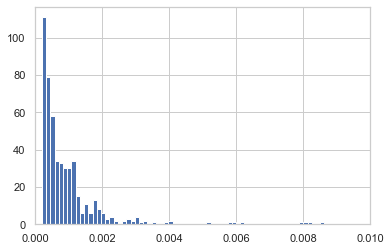

In [173]:
plt.hist(data.dropna(), bins=500)
plt.xlim((0,0.01))
plt.show()

In [144]:
### Weighted job placement bac vs mas:

In [59]:
from scipy import stats
data_1 = h1_s1["weighted job placement"].dropna()
data_2 = h1_s2["weighted job placement"].dropna()
stat, p_val = stats.ttest_ind(data_1, data_2)
print(p_val)
if p_val > 0.05:
    print("We fail to reject the null hypothesis. Our datasets are not proven to be statistically different")
elif p_val < 0.05:
    print("We reject the null hypothesis. Our datasets are statistically different")
print(f'Bac degree weighted placement mean: {data_1.mean()}')
print(f'Mas degree weighted placement mean: {data_2.mean()}')

0.35242204987969594
We fail to reject the null hypothesis. Our datasets are not proven to be statistically different
Bac degree weighted placement mean: 0.0017000983908337822
Mas degree weighted placement mean: 0.0014302657842529736


In [60]:
### NONWeighted job placement bac vs mas:

In [61]:
from scipy import stats
data_1 = h1_s1["Taux d’insertion"].dropna()
data_2 = h1_s2["Taux d’insertion"].dropna()
stat, p_val = stats.ttest_ind(data_1, data_2)
print(p_val)
if p_val > 0.05:
    print("We fail to reject the null hypothesis. Our datasets are not proven to be statistically different")
elif p_val < 0.05:
    print("We reject the null hypothesis. Our datasets are statistically different")
print(f'Bac degree placement mean: {data_1.mean()}')
print(f'Mas degree placement mean: {data_2.mean()}')

8.793186851147393e-25
We reject the null hypothesis. Our datasets are statistically different
Bac degree placement mean: 93.85220729366603
Mas degree placement mean: 91.06445837063563


In [62]:
### Weighted full time job placement bac vs mas:

In [63]:
from scipy import stats
data_1 = h1_s1["weighted ft job placement"].dropna()
data_2 = h1_s2["weighted ft job placement"].dropna()
stat, p_val = stats.ttest_ind(data_1, data_2)
print(p_val)
if p_val > 0.05:
    print("We fail to reject the null hypothesis. Our datasets are not proven to be statistically different")
elif p_val < 0.05:
    print("We reject the null hypothesis. Our datasets are statistically different")
print(f'Bac degree weighted full time placement mean: {data_1.mean()}')
print(f'Mas degree weighted full time placement mean: {data_2.mean()}')

2.6155289959687123e-05
We reject the null hypothesis. Our datasets are statistically different
Bac degree weighted full time placement mean: 0.0017436598777311933
Mas degree weighted full time placement mean: 0.0007924678555576962


In [64]:
### NONWeighted job placement bac vs mas:

In [65]:
from scipy import stats
data_1 = h1_s1["taux temp plein - out of number of answers"].dropna()
data_2 = h1_s2["taux temp plein - out of number of answers"].dropna()
stat, p_val = stats.ttest_ind(data_1, data_2)
print(p_val)
if p_val > 0.05:
    print("We fail to reject the null hypothesis. Our datasets are not proven to be statistically different")
elif p_val < 0.05:
    print("We reject the null hypothesis. Our datasets are statistically different")
print(f'Bac degree nonweighted full time placement mean: {data_1.mean()}')
print(f'Mas degree nonweighted full time placement mean: {data_2.mean()}')

6.962056511114023e-28
We reject the null hypothesis. Our datasets are statistically different
Bac degree nonweighted full time placement mean: 92.1743232323233
Mas degree nonweighted full time placement mean: 88.55695062923529


In [ ]:
For presentation: discuss weighted values.

### Second hypothesis: Higher ranked schools give same job placement as the rest of schools.

In [179]:
import functions as f

df_all["students number w_job"] = df_all["Nombre de réponses"] * df_all["Taux d’insertion"]/100
df_all["students number w_fulltime_job"] = df_all["students number w_job"] * df_all["% emplois à temps plein"]/100
df_all["taux temp plein - out of number of answers"] = df_all["Taux d’insertion"] * df_all["% emplois à temps plein"]/100
df_all.info() 
cols_to_keep = [0,1,4,6, 8,9,10, 11,16,22, 23, 24, 25]
df_hyp2 = f.keep_columns(df_all, cols_to_keep)
df_hyp2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16214 entries, 0 to 16213
Data columns (total 26 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Annee                                         16214 non-null  float64
 1   Diplôme                                       16214 non-null  object 
 2   Numéro de l'établissement                     16214 non-null  object 
 3   Académie                                      15827 non-null  object 
 4   Domaine                                       16214 non-null  object 
 5   Discipline                                    16180 non-null  object 
 6   situation                                     16214 non-null  object 
 7   Remarque                                      0 non-null      object 
 8   Nombre de réponses                            16207 non-null  float64
 9   Taux de réponse                               16069 non-null  floa

In [180]:
d_domain_1 = 'LICENCE PRO Sciences, technologies et santé'
d_domain_2 = 'MASTER LMD Sciences, technologies et santé'
d_domain_3 = 'DOCTORAT Sciences et leurs interactions'

In [189]:
time_per = 3
cond_1 = df_hyp2["situation"] == tperiod(time_per)[0]
cond_2 = df_hyp2["situation"] == tperiod(time_per)[1]
cond_3 = df_hyp2["rank"].notnull()
cond_4 = df_hyp2["rank"].isnull()

h2_s1_hr = df_hyp2[(df_hyp2["Diploma Domain"] == d_domain_1) & (cond_1 | cond_2) & (cond_3)][:]#.dropna()
h2_s1_lr = df_hyp2[(df_hyp2["Diploma Domain"] == d_domain_1) & (cond_1 | cond_2) & (cond_4)][:]#.dropna()

# h2_s2 = df_hyp1[(df_hyp1["Diploma Domain"] == d_domain_2) & (cond_1 | cond_2)].dropna()
# h2_s3 = df_hyp1[(df_hyp1["Diploma Domain"] == d_domain_3) & (cond_1 | cond_2)].dropna()

In [190]:
ntot1_hr = h2_s1_hr["Nombre de réponses"].sum()
ntot1_lr = h2_s1_lr["Nombre de réponses"].sum()

# ntot2 = h1_s2["Nombre de réponses"].sum()
# ntot3 = h1_s3["Nombre de réponses"].sum()

h2_s1_hr["weighted job placement"] = h2_s1_hr["students number w_job"] / ntot1_hr
h2_s1_hr["weighted ft job placement"] = h2_s1_hr["students number w_fulltime_job"] / ntot1_hr
h2_s1_lr["weighted job placement"] = h2_s1_lr["students number w_job"] / ntot1_lr
h2_s1_lr["weighted ft job placement"] = h2_s1_lr["students number w_fulltime_job"] / ntot1_lr

# h1_s2["weighted job placement"] = h1_s2["students number w_job"] / ntot1
# h1_s2["weighted ft job placement"] = h1_s2["students number w_fulltime_job"] / ntot2

# h1_s3["weighted job placement"] = h1_s3["students number w_job"] / ntot1
# h1_s3["weighted ft job placement"] = h1_s3["students number w_fulltime_job"] / ntot3

In [197]:
# shapiro normality test
from scipy.stats import shapiro

alpha = 0.05
data = h2_s1_hr["weighted job placement"].dropna()
stat, p = shapiro(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=0.846, p=0.000
Probably not Gaussian


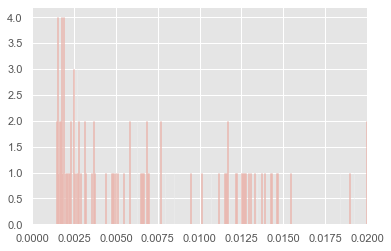

In [198]:
plt.style.use('ggplot')
plt.hist(data, bins=500)
plt.xlim((0,0.02))
plt.show()

In [ ]:
### Weighted job placement bac high rank vs low rank:

In [201]:
from scipy import stats
data_1 = h2_s1_hr["weighted job placement"].dropna()
data_2 = h2_s1_lr["weighted job placement"].dropna()
stat, p_val = stats.ttest_ind(data_1, data_2)
print(p_val)
if p_val > 0.05:
    print("We fail to reject the null hypothesis. Our datasets are not proven to be statistically different")
elif p_val < 0.05:
    print("We reject the null hypothesis. Our datasets are statistically different")
print(f'Bac degree weighted placement mean - high rank univs: {data_1.mean()}')
print(f'Bac degree weighted placement mean - low rank univs: {data_2.mean()}')

9.026666860964977e-11
We reject the null hypothesis. Our datasets are statistically different
Bac degree weighted placement mean - high rank univs: 0.007535383741010342
Bac degree weighted placement mean - low rank univs: 0.002194322110698645


In [146]:
### NONWeighted job placement bac high rank vs low rank:

In [203]:
from scipy import stats
data_1 = h2_s1_hr["Taux d’insertion"].dropna()
data_2 = h2_s1_lr["Taux d’insertion"].dropna()
stat, p_val = stats.ttest_ind(data_1, data_2)
print(p_val)
if p_val > 0.05:
    print("We fail to reject the null hypothesis. Our datasets are not proven to be statistically different")
elif p_val < 0.05:
    print("We reject the null hypothesis. Our datasets are statistically different")
print(f'Bac degree NON-weighted placement mean - high rank univs: {data_1.mean()}')
print(f'Bac degree NON-weighted placement mean - low rank univs: {data_2.mean()}')

0.8017020536157565
We fail to reject the null hypothesis. Our datasets are not proven to be statistically different
Bac degree NON-weighted placement mean - high rank univs: 93.77777777777777
Bac degree NON-weighted placement mean - low rank univs: 93.87376237623762


In [148]:
### Weighted full time job placement bac high rank vs low rank:

In [204]:
from scipy import stats
data_1 = h2_s1_hr["weighted ft job placement"].dropna()
data_2 = h2_s1_lr["weighted ft job placement"].dropna()
stat, p_val = stats.ttest_ind(data_1, data_2)
print(p_val)
if p_val > 0.05:
    print("We fail to reject the null hypothesis. Our datasets are not proven to be statistically different")
elif p_val < 0.05:
    print("We reject the null hypothesis. Our datasets are statistically different")
print(f'Bac degree weighted full time placement mean - high rank univs: {data_1.mean()}')
print(f'Bac degree weighted full time placement mean - low rank univs: {data_2.mean()}')

9.998773244267078e-11
We reject the null hypothesis. Our datasets are statistically different
Bac degree weighted full time placement mean - high rank univs: 0.007741321213796917
Bac degree weighted full time placement mean - low rank univs: 0.0022495154417657482


In [150]:
### NONWeighted full time job placement bac high rank vs low rank:

In [206]:
from scipy import stats
data_1 = h2_s1_hr["taux temp plein - out of number of answers"].dropna()
data_2 = h2_s1_lr["taux temp plein - out of number of answers"].dropna()
stat, p_val = stats.ttest_ind(data_1, data_2)
print(p_val)
if p_val > 0.05:
    print("We fail to reject the null hypothesis. Our datasets are not proven to be statistically different")
elif p_val < 0.05:
    print("We reject the null hypothesis. Our datasets are statistically different")
print(f'Bac degree nonweighted full time placement mean - high rank univs: {data_1.mean()}')
print(f'Bac degree nonweighted full time placement mean - low rank univs: {data_2.mean()}')

0.44428292835840943
We fail to reject the null hypothesis. Our datasets are not proven to be statistically different
Bac degree nonweighted full time placement mean - high rank univs: 92.45900900900901
Bac degree nonweighted full time placement mean - low rank univs: 92.09203125000009


In [67]:
df_hyp1

,Annee,Diplôme,Domaine,situation,Nombre de réponses,Taux de réponse,Taux d’insertion,% emplois à temps plein,Diploma Domain,taux temp plein - out of number of answers,rank,students number w_job,students number w_fulltime_job
0,2013.0,LICENCE PRO,"Droit, économie et gestion",18 mois après le diplôme,85.0,74.0,90.0,99.0,"LICENCE PRO Droit, économie et gestion",89.10,NaN,76.5,75.735
1,2013.0,LICENCE PRO,"Lettres, langues, arts",30 mois après le diplôme,8.0,77.0,NaN,NaN,"LICENCE PRO Lettres, langues, arts",NaN,NaN,NaN,NaN
2,2013.0,LICENCE PRO,"Sciences, technologies et santé",18 mois après le diplôme,105.0,84.0,86.0,98.0,"LICENCE PRO Sciences, technologies et santé",84.28,NaN,90.3,88.494
3,2013.0,LICENCE PRO,"Sciences, technologies et santé",18 mois après le diplôme,24.0,77.0,NaN,NaN,"LICENCE PRO Sciences, technologies et santé",NaN,NaN,NaN,NaN
4,2013.0,LICENCE PRO,"Sciences, technologies et santé",30 mois après le diplôme,49.0,87.0,90.0,89.0,"LICENCE PRO Sciences, technologies et santé",80.10,NaN,44.1,39.249
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Université de Toulouse 3 - Paul Sabatier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN
Université de Bordeaux,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN
Université Toulouse 1 - Capitole,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN
Université de Lille,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN
